# Regression Dataset

En la práctica, nunca vamos a conocer el verdadero proceso que genera los datos (si lo conocieramos, no necesitaríamos utilizar técnicas de machine learning). El valor de simular ese proceso, es que nos va permitir conocer exactamente su distribución y eso nos va ayudar a entender que tan buenas son nuestras estimaciones y mejorar nuestra intuición sobre los distintos conceptos y métodos.


## The (synthetic) dataset

En vez de jugar con datos reales, vamos a crear nuestros datos ya que conocer exactamente como fueron creados nos va ayudar a experimentar con los conceptos que queremos aprender.

Una manera de obtener una fuente de datos infinita es creando una "maquina generadora de datos". Esa "máquina" la podemos especificar describiendo el proceso a través del cual la "máquina" va a poder generar datos.






Una manera posible, podría ser comenzar con una función $f$, donde

$$f(x) = (0.45x-2)^3 - 0.55(0.2x-3)^2- 2.5(0.5x - 3)+ 5$$

y agregarle ruido $\epsilon$ para tener entonces una variable aletoria

$$ Y = f(x) + \epsilon. $$

Para nuestro ejercicio, tomemos $\epsilon \sim N(\mu=0,\sigma^2 = 0.5)$.

Para hacerlo todavía más entretenido, vamos a hacer que las $x$ de nuestro dataset también tengan una distribución, por ejemplo, $X \sim U(a=0,b=10) $.

Nota: Elegí una $f(x)$ con una forma "bastante curva" para que sean más entretenidos nuestros experimentos y nos restringimos a $x \in [0,10]$ (cómo $\mathbb{x}$ es un escalar, usamos la notación $x$ en vez de $\mathbb{x}$) para facilitar la visualización.

Con todo esto, nos queda entonces el siguiente proceso de generación de datos: $ Y = f(X) + \epsilon$ , con $X \sim U(a=0,b=10) $ y $\epsilon \sim N(\mu=0,\sigma^2 = 0.5)$.

Para "usar la máquina" en este caso y generar una muestra $(x_0,y_0)$, empezamos sampleando $x_0$ de la distribución uniforme, después pasamos $x_0$ por $f$ y obtemos $f(x_0)$, sampleamos $\epsilon_0$ de la normal (con $\mu=0$ y $\sigma^2 = 0.5$ ) y finalemente obtenemos $y_0 = f(x_0) + \epsilon_0$.

Este mismo proceso se puede escribir de la siguiente manera:

$$ Y|X \sim \mathcal{N}(y|\mu =f(x),{\sigma}^2 = 0.5)$$  
$$ X \sim \mathcal{U}(x|a=0,b=10)$$

Esto se conoce como un modelos jerarquico ({cite}`casella_statistical_2001`, Pag 162) y es para mí una forma muy simple e intuitiva de describir un proceso de generación de datos.

Para "usar la máquina" descripta de esta manera y generar una muestra $(x_0,y_0)$, empezamos sampleando $x_0$ de la distribución uniforme. Después, "pasamos" $x_0$ por $f$ para obtener $f(x_0)$. Finalmente sampleamos $y_0$ de una normal con $\mu=f(x_0)$ y $\sigma^2 = 0.5$. A este proceso de generar muestras se lo conoce como ancestral sampling ({cite}`bishop_pattern_2007`, Pag 365).

Noten que las dos descripciones, aunque son ligeramente diferentes, son completamente equivalentes (van a generar datos con exactamente la misma distribución) y me permiten generar tantos pares $(x,y)$ como queramos.

## Data distribution $Pr(X,Y)$


En este caso, podemos escribir $\text{Pr}(X,Y)$ de manera analítica,

\begin{align*}
\text{Pr}(X,Y) &= \text{Pr}(Y|X) \, \text{Pr}(X) && \text{(aplicando chain rule)} \\
&= \mathcal{N}(y|\mu =f(x),{\sigma}^2 = 0.5)\, \mathcal{U}(x|a=0,b=10) && \text{(reemplazando por las definiciones)} \\
&= \frac{1}{\sqrt{2\pi\sigma^2}}\text{exp} \Big\{-\frac{1}{2\sigma^2}(y-f(x))^2\Big\} \frac{1}{b-a} \\
&= \frac{1}{10\sqrt{\pi}}\text{exp} \Big\{-(y-f(x))^2\Big\} && \text{(reemplazando los valores de los parámetros)} .
\end{align*}

Dónde usamos que $\mathcal{N}(y | \mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\text{exp} \Big\{-\frac{1}{2\sigma^2}(y-\mu)^2\Big\}$ y $\mathcal{U}(x|a,b) = \frac{1}{b-a}$.


In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt

## The training datasets

Generamos los datos usando la descripción de función con ruido.

In [11]:
# Create d datasets of n samples each
d = 5 # number of datasets to create
n = 100 # samples per dataset
a, b = 0,10 # x domain range (a,b)
f = np.vectorize(lambda x :  (0.45*x-2)**3 - 0.55*(0.2*x-3)**2-2.5*(0.5*x-3)+ 5) # True function that we would like to learn
var = 0.5 # Noise to add to the true function

In [12]:
# Seed for the random generator
rng = default_rng(12345)

In [13]:
def generate_datasets(d:int,n:int,f:np.vectorize,a:float,b:float,var:float):
    """
    Creates datasets.

    Parameters
    ----------

    d: number of datasets
    n: number of samples per dataset
    f: function to use to generate the data
    a: min of range x
    b: max of range x
    var: variance of the normal use to generate the noise

    Returns
    -------
    X: datasets with features
    Y: datasets with targets

    """
    X = rng.uniform(low=a,high=b,size=(d,n))
    noise = rng.normal(loc=0,scale=np.sqrt(var),size=(d,n))
    Y = f(X) + noise # True labels 
    return X,Y

In [14]:
X_trains, y_trains = generate_datasets(d,n,f,a,b,var)

## The test dataset

In [8]:
d_test = 1
n_test = 20

X_tests, y_tests = generate_datasets(d_test,n_test,f=f,a=a,b=b,var=var)

## True $f$ (for future reference) 

In [7]:
true_f_x = np.linspace(a,b,1000)
true_f_y = f(true_f_x)

## Save the datasets

In [9]:
def to_Xy_df(X,y):
    """
    Converts a numpy dataset into a dataframe dataset.
    Assumes X and y with shape (samples).
    """
    Xy = np.concatenate([X.reshape(-1,1), y.reshape(-1,1)],axis=1)
    Xy_df = pd.DataFrame(data = Xy.copy(), columns = ["X","y"])
    return Xy_df

Xy_train_df = to_Xy_df(X_trains[0],y_trains[0]) 
Xy_test_df = to_Xy_df(X_tests[0],y_tests[0])

In [10]:
# Xy_train_df.to_csv("data/Xy_train.csv",index=False)
# Xy_test_df.to_csv("data/Xy_test.csv",index=False)

## Plot one training dataset

In [18]:
def plot_f(i: int,x_datasets: np.array,y_datasets_w_noise: np.array,true_f_x: np.array,true_f_y: np.array):
    """
    Plot the function and the data coming from it for specific dataset i in x_datasets.
    i: index to indicate which dataset to plot from x_datasets.
    x_datasets: input features of the d datatsets.
    y_datasets_w_noise: targets of the d datasets.
    true_f_x: x coordinates of the points from the true function.
    true_f_y: y cordinates of the points from the true function.
    """
    fig,ax = plt.subplots(figsize=(7,7))
    ax.set_ylim((-4,18))
    ax.set_xlim((0,10))
    ord = x_datasets[i,:].argsort()
    ax.plot(true_f_x,true_f_y,color='blue')
    ax.scatter(x_datasets[i,:],y_datasets_w_noise[i,:],color = 'orange')
    return ax

<AxesSubplot:>

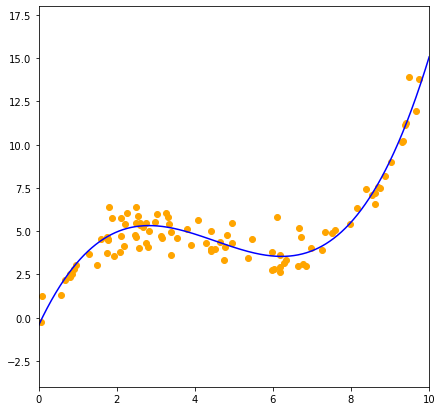

In [19]:
plot_f(i=0, x_datasets=X_trains, y_datasets_w_noise=y_trains, true_f_x=true_f_x ,true_f_y=true_f_y)

## References

```{bibliography} ./references.bib
:filter: docname in docnames
```